### Question 2: Gaussian, Spatial (Box), Median, and Temporal Smoothing

In [1]:
import cv2
import numpy as np
import scipy
import glob
from skimage.registration import phase_cross_correlation
from plot_utils import *

image = cv2.imread('retina2/172.bmp', cv2.COLOR_BGR2GRAY)

image_paths = glob.glob('retina2/*.bmp')
input_images = [cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in image_paths]

### Smoothing

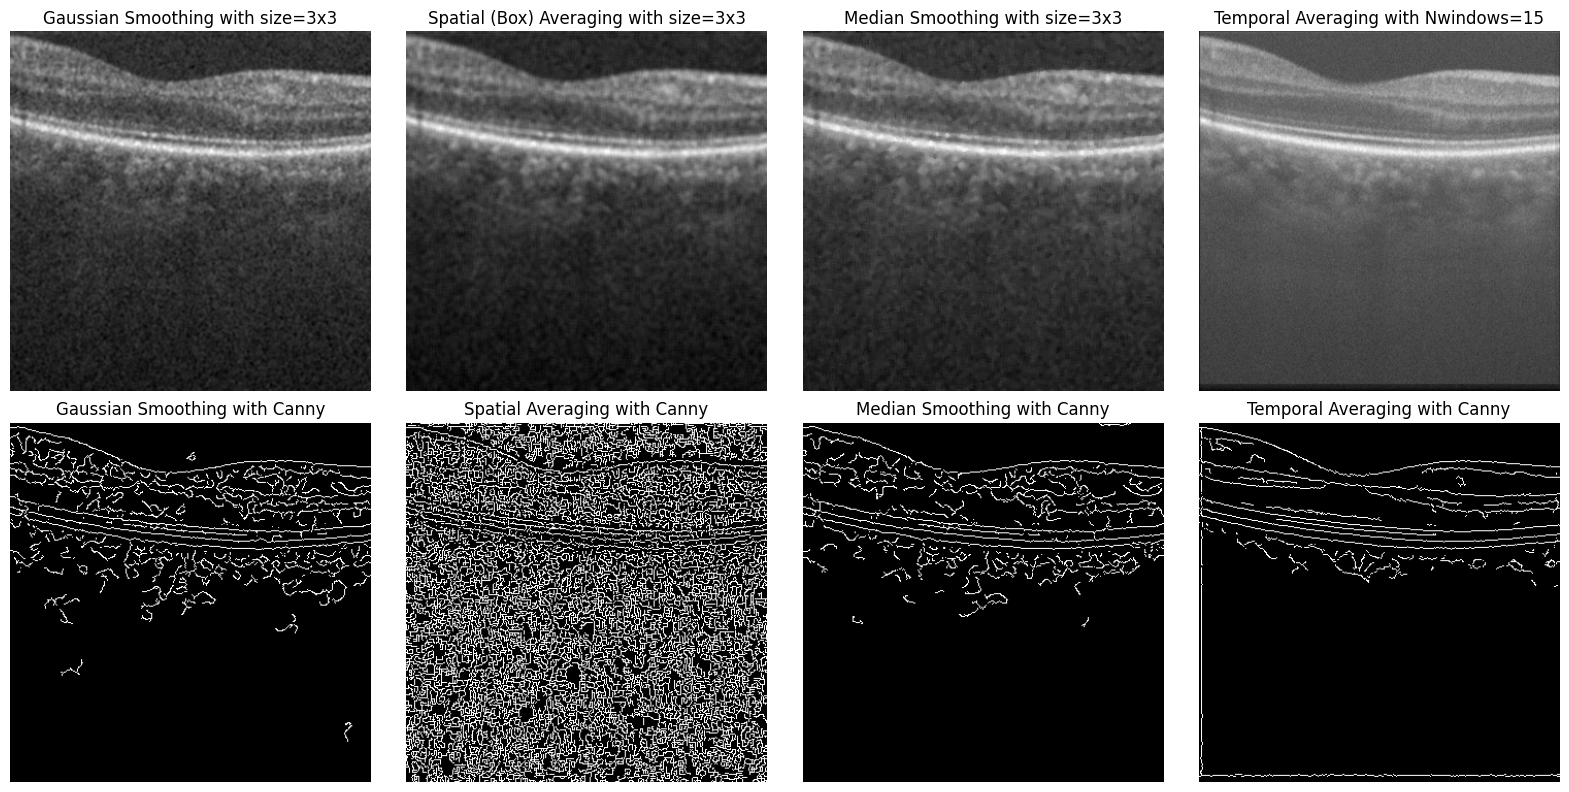

In [2]:
ksize = 5
# Gaussian Smoothing
gaussian = cv2.GaussianBlur(image, (ksize, ksize), 1)

# Spatial (Box) Averaging
spatial = cv2.blur(image, (ksize, ksize))

# Median Smoothing
median = cv2.medianBlur(image, ksize)

# Temporal Averaging
offset = 0
n = 15
first_image = input_images[offset]
corrected_images = []
for i in range(offset, offset+n):
    offset_image = input_images[i]
    shift, error, diffphase = phase_cross_correlation(first_image, offset_image, upsample_factor=100, overlap_ratio=0.9)
    corrected_image = scipy.ndimage.shift(offset_image, shift)
    corrected_images.append(corrected_image)
temporal = np.mean(corrected_images, axis=0).astype(np.uint8)

# Canny Edge Detector
lower, upper, ksize = 0.05*temporal.max(), 0.15*temporal.max(), 3

gaussian_c = cv2.GaussianBlur(gaussian, (0, 0), 2)
gaussian_c = cv2.Canny(gaussian_c, lower, upper, ksize)

spatial_c = cv2.GaussianBlur(spatial, (0, 0), 2)
spatial_c = cv2.Canny(spatial, lower, upper, ksize)

median_c = cv2.GaussianBlur(median, (0, 0), 2)
median_c = cv2.Canny(median_c, lower, upper, ksize)

temporal_c = cv2.GaussianBlur(temporal, (0, 0), 2)
temporal_c = cv2.Canny(temporal_c, lower, upper, ksize)

images = [[gaussian, spatial, median, temporal], [gaussian_c, spatial_c, median_c, temporal_c]]
titles = [[f'Gaussian Smoothing with size={ksize}x{ksize}', f'Spatial (Box) Averaging with size={ksize}x{ksize}', 
           f'Median Smoothing with size={ksize}x{ksize}', 'Temporal Averaging with Nwindows=15'],
           ['Gaussian Smoothing with Canny', 'Spatial Averaging with Canny', 'Median Smoothing with Canny', 
            'Temporal Averaging with Canny']]

plot_images(images, titles, dpi=100)

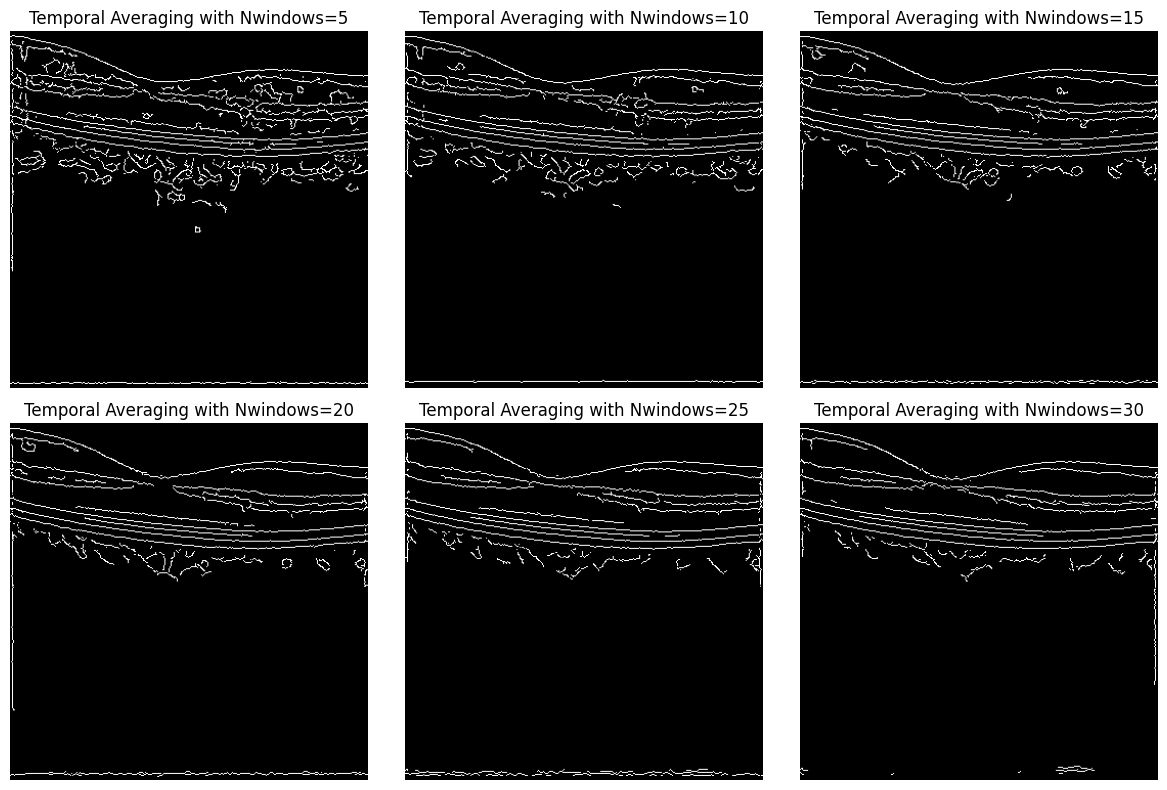

In [3]:
# Temporal Averaging Experiments on Nwindows
n_values = [5, 10, 15, 20, 25, 30]
temporal_list = []
canny_list = []

for n in n_values:
    offset = 0
    first_image = input_images[offset]
    corrected_images = []
    for i in range(offset, offset+n):
        offset_image = input_images[i]
        shift, error, diffphase = phase_cross_correlation(first_image, offset_image, upsample_factor=100,
                                                          overlap_ratio=0.9, normalization=None)
        corrected_image = scipy.ndimage.shift(offset_image, shift)
        corrected_images.append(corrected_image)
    temporal = np.mean(corrected_images, axis=0).astype(np.uint8)
    temporal_list.append(temporal)
    temporal_b = cv2.GaussianBlur(temporal, (0, 0), 2)
    temporal_c = cv2.Canny(temporal_b, 0.05*temporal.max(), 0.15*temporal.max(), 3)
    canny_list.append(temporal_c)

images = [[canny_list[0], canny_list[1], canny_list[2]], [canny_list[3], canny_list[4], canny_list[5]]]
titles = [['Temporal Averaging with Nwindows=5', 'Temporal Averaging with Nwindows=10', 'Temporal Averaging with Nwindows=15'],
           ['Temporal Averaging with Nwindows=20','Temporal Averaging with Nwindows=25', 'Temporal Averaging with Nwindows=30']]

plot_images(images, titles, dpi=100)

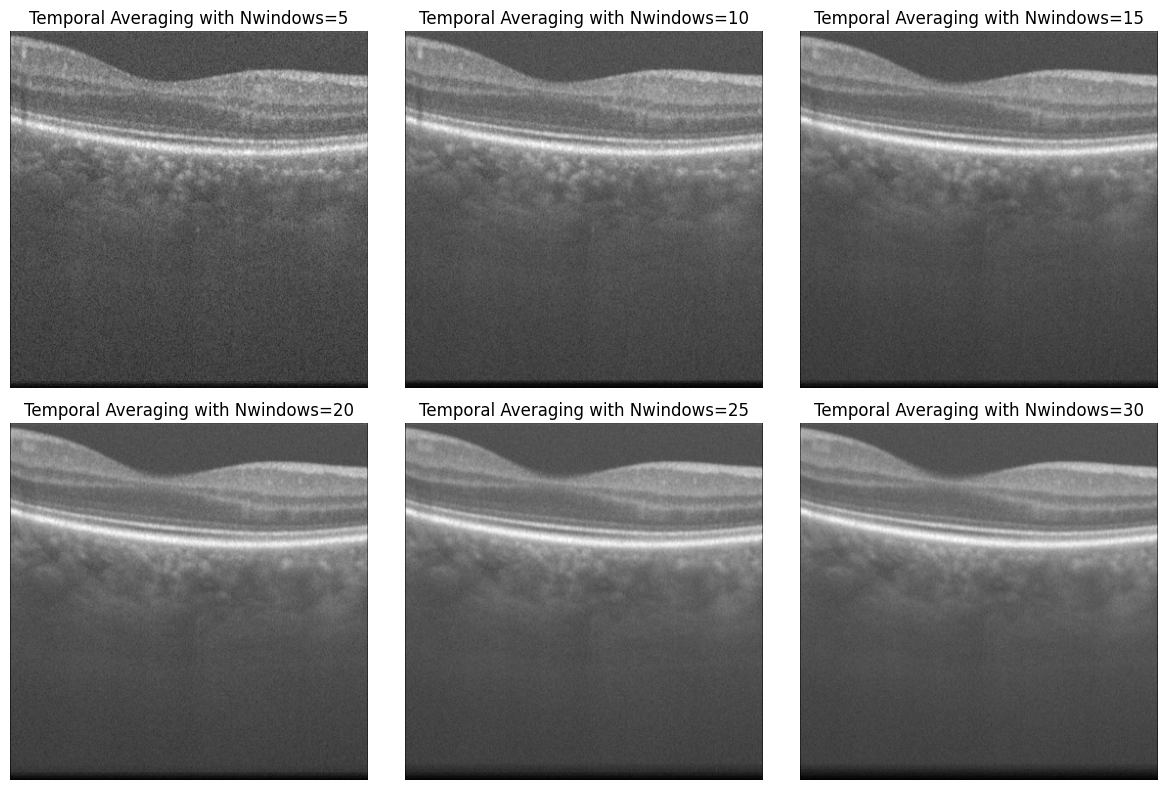

In [4]:
images = [[temporal_list[0], temporal_list[1], temporal_list[2]], [temporal_list[3], temporal_list[4], temporal_list[5]]]
titles = [['Temporal Averaging with Nwindows=5', 'Temporal Averaging with Nwindows=10', 'Temporal Averaging with Nwindows=15'],
           ['Temporal Averaging with Nwindows=20','Temporal Averaging with Nwindows=25', 'Temporal Averaging with Nwindows=30']]

plot_images(images, titles, dpi=100)

### Canny Edge Detection Hyperparameter Tuning

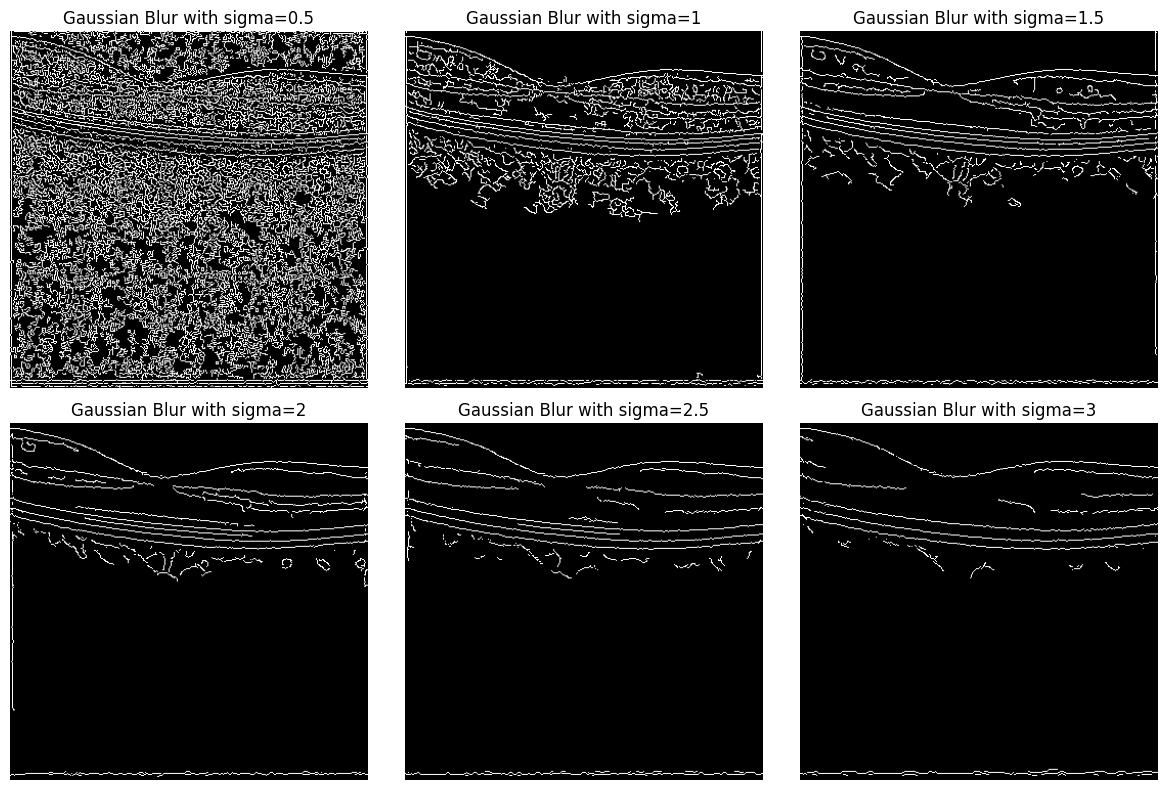

In [5]:
# Nwindows = 20 is the best
temporal_img = temporal_list[3]

# Canny Parameters Experiments with varying sigma of Gaussian filters
sigma_values = [0.5, 1, 1.5, 2, 2.5, 3]
canny_list = []
lower = np.round(0.05 * temporal.max(), 1)
upper = np.round(0.15 * temporal.max(), 1)
for sigma in sigma_values:
    temporal_c = cv2.GaussianBlur(temporal_img, (0, 0), sigma)
    temporal_c = cv2.Canny(temporal_c, lower, upper, 3)
    canny_list.append(temporal_c)  

images = [[canny_list[0], canny_list[1], canny_list[2]], [canny_list[3], canny_list[4], canny_list[5]]]
titles = [[f'Gaussian Blur with sigma={sigma_values[0]}', f'Gaussian Blur with sigma={sigma_values[1]}', f'Gaussian Blur with sigma={sigma_values[2]}'],
           [f'Gaussian Blur with sigma={sigma_values[3]}', f'Gaussian Blur with sigma={sigma_values[4]}', f'Gaussian Blur with sigma={sigma_values[5]}']]

plot_images(images, titles, dpi=100)

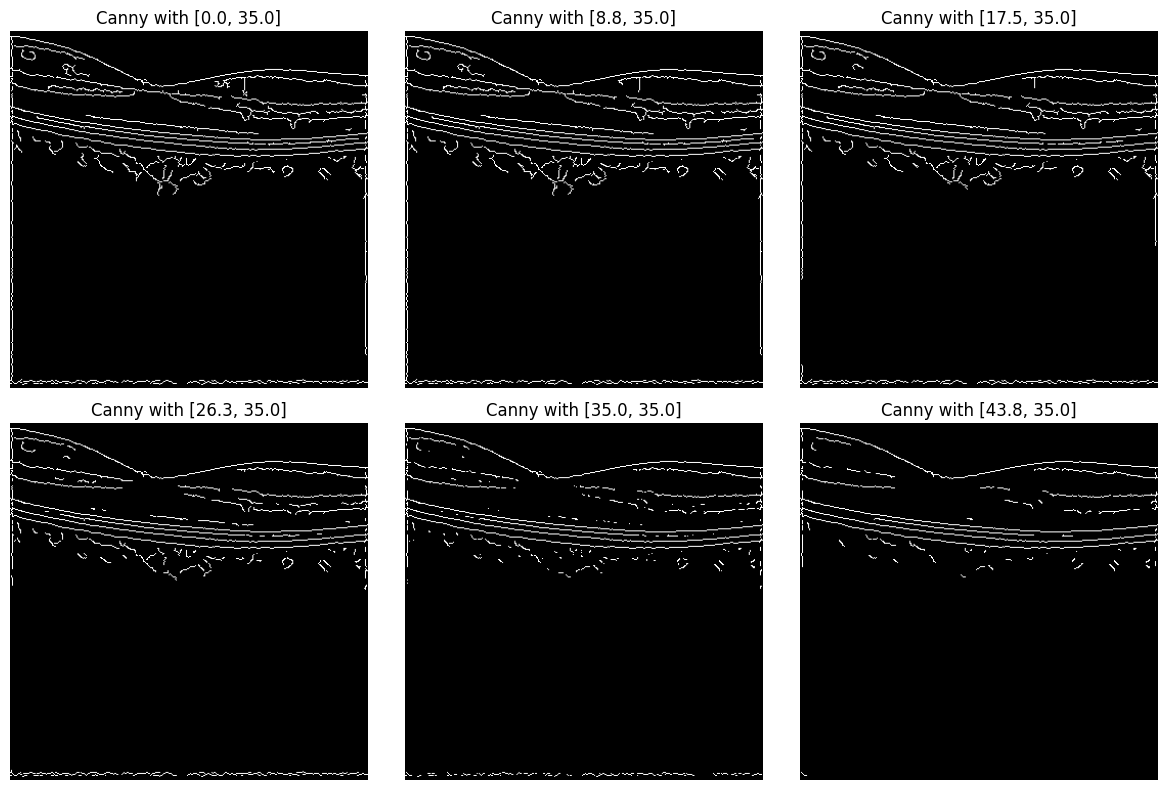

In [6]:
sigma = 1.5

# Canny Parameters Experiments with varying lower threshold values
lower_values = np.round(np.arange(0.00, 0.3, 0.05) * temporal.max(), 1)
upper = np.round(0.20 * temporal.max(), 1)
canny_list = []
for lower in lower_values:
    temporal_c = cv2.GaussianBlur(temporal_img, (0, 0), sigma)
    temporal_c = cv2.Canny(temporal_c, lower, upper, 3)
    canny_list.append(temporal_c)  

images = [[canny_list[0], canny_list[1], canny_list[2]], [canny_list[3], canny_list[4], canny_list[5]]]
titles = [[f'Canny with [{lower_values[0]}, {upper}]', f'Canny with [{lower_values[1]}, {upper}]',
           f'Canny with [{lower_values[2]}, {upper}]'],
          [f'Canny with [{lower_values[3]}, {upper}]', f'Canny with [{lower_values[4]}, {upper}]', 
           f'Canny with [{lower_values[5]}, {upper}]']]

plot_images(images, titles, dpi=100)

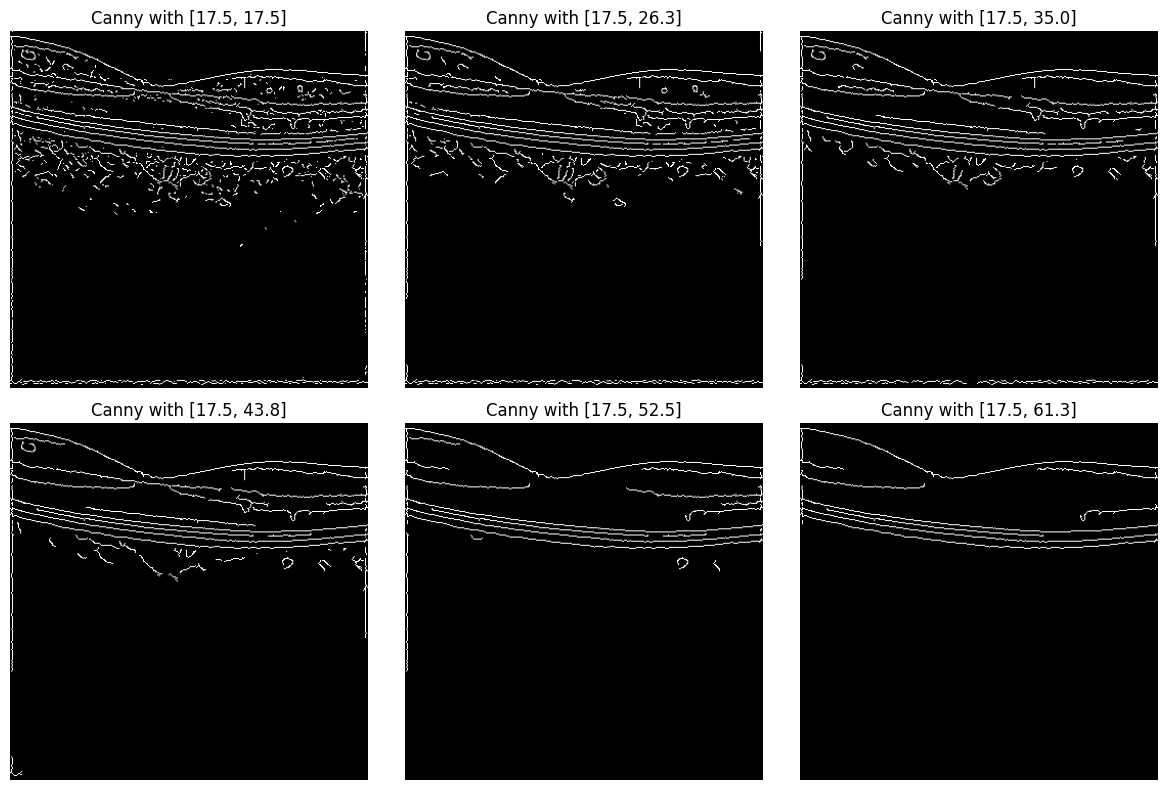

In [7]:
# Canny Parameters Experiments with varying upper threshold values
upper_values = np.round(np.arange(0.10, 0.40, 0.05) * temporal.max(), 1)
lower = np.round(0.10 * temporal.max(), 1)
canny_list = []
for upper in upper_values:
    temporal_c = cv2.GaussianBlur(temporal_img, (0, 0), sigma)
    temporal_c = cv2.Canny(temporal_c, lower, upper, 3)
    canny_list.append(temporal_c)  

images = [[canny_list[0], canny_list[1], canny_list[2]], [canny_list[3], canny_list[4], canny_list[5]]]
titles = [[f'Canny with [{lower}, {upper_values[0]}]', f'Canny with [{lower}, {upper_values[1]}]',
          f'Canny with [{lower}, {upper_values[2]}]'], [f'Canny with [{lower}, {upper_values[3]}]', 
           f'Canny with [{lower}, {upper_values[4]}]', f'Canny with [{lower}, {upper_values[5]}]']]

plot_images(images, titles, dpi=100)

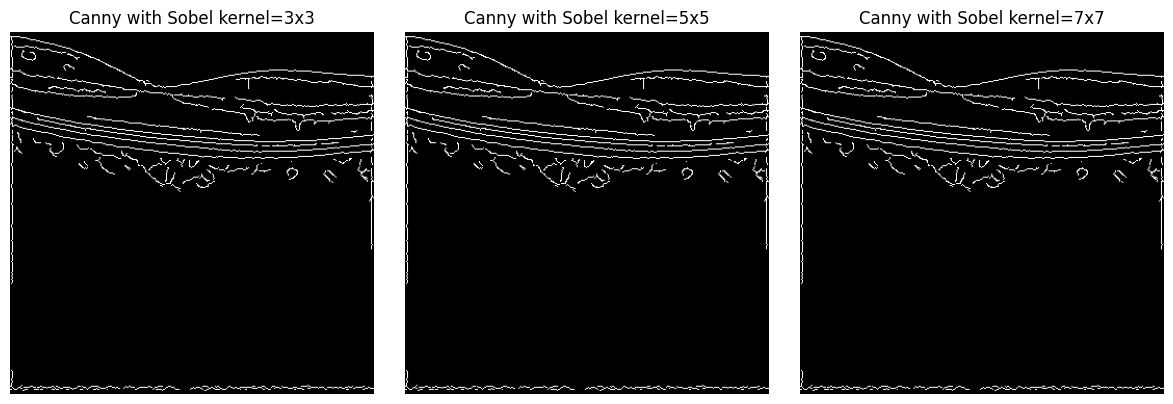

In [8]:
# Canny Parameters Experiments with varying aperture size of Sobel filters
aperture_sizes = [3, 5, 7]
canny_list = []
lower = np.round(0.1 * temporal.max(), 1)
upper = np.round(0.2 * temporal.max(), 1)
for size in aperture_sizes:
    temporal_c = cv2.GaussianBlur(temporal_img, (0, 0), sigma)
    temporal_c = cv2.Canny(temporal_c, lower, upper, size)
    canny_list.append(temporal_c)  

images = [[canny_list[0], canny_list[1], canny_list[2]]]
titles = [['Canny with Sobel kernel=3x3', 'Canny with Sobel kernel=5x5', 'Canny with Sobel kernel=7x7']]

plot_images(images, titles, dpi=100)

### Special Techniques: Hough Transform

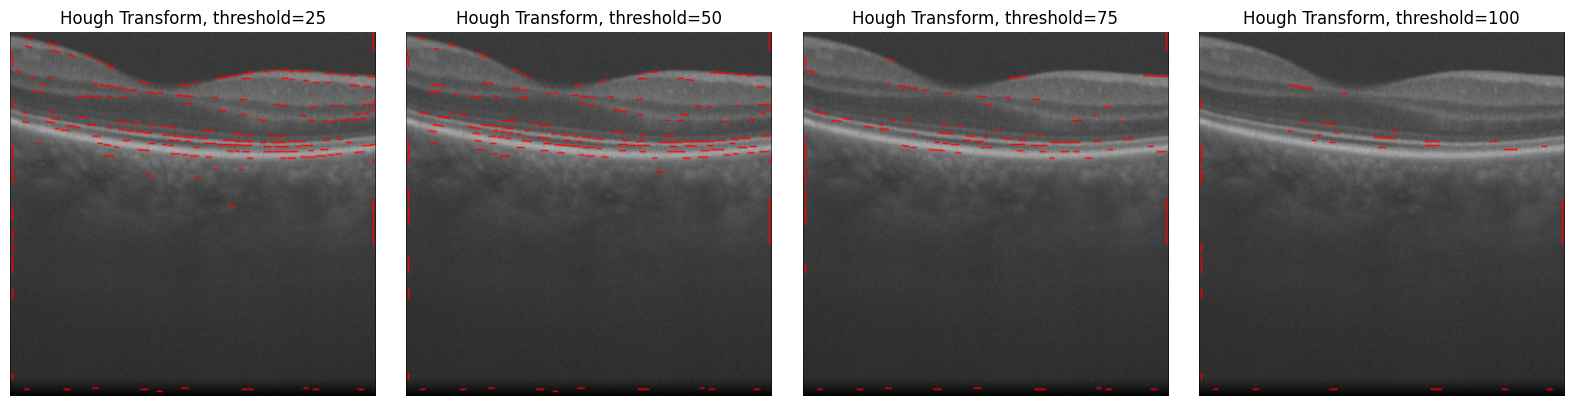

In [9]:
temporal_c = cv2.GaussianBlur(temporal_img, (0, 0), 1.5)
temporal_c = cv2.Canny(temporal_c, 17.5, 26.3, 3)

ht_temporal = np.repeat(np.expand_dims(temporal, axis=2), 3, axis=2)
images = [[None for _ in range(4)]]
titles = [[]]

minLineLength = 10
maxLineGap = 5

for i, threshold in enumerate(range(25, 124, 25)):
    ht_temporal_draw = ht_temporal.copy()
    lines = cv2.HoughLinesP(temporal_c, cv2.HOUGH_PROBABILISTIC, np.pi/180, threshold, minLineLength, maxLineGap)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(ht_temporal_draw, (x1, y1), (x2, y2), (255,0,0), 1, cv2.LINE_AA)
    images[0][i] = ht_temporal_draw
    titles[0].append(f'Hough Transform, threshold={threshold}')

plot_images(images, titles, dpi=100, cmap=None)

### Special Techniques: Deep Learning

In [10]:
# This class helps in cropping the specified coordinated in the function

class CropLayer(object):
    
    def __init__(self, params, blobs):

        # initialize our starting and ending (x, y)-coordinates of
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):

        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        return [inputs[0][:, :, self.startY:self.endY,self.startX:self.endX]]

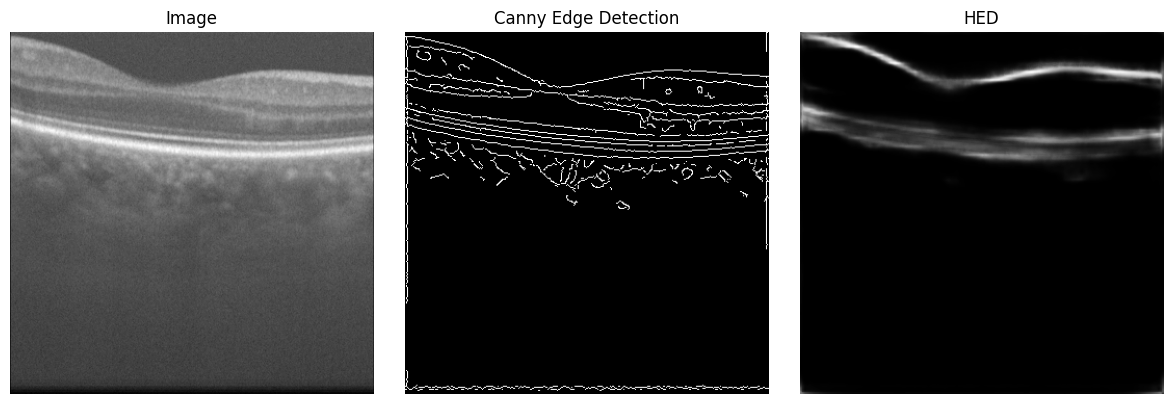

In [11]:
# The caffemodel contains the model of the architecture and the deploy.prototxt contains the weights 
net = cv2.dnn.readNetFromCaffe('hed_deploy.prototxt.txt', 'hed_pretrained_bsds.caffemodel')

# Register our new layer with the model
cv2.dnn_registerLayer('Crop', CropLayer)
(H, W) = temporal_img.shape[:2]
hed_img = np.repeat(np.expand_dims(temporal_img, axis=2), 3, axis=2)

# Input image is converted to a blob
blob = cv2.dnn.blobFromImage(hed_img, scalefactor=1.0, size=(W, H),
                             mean=(104.00698793, 116.66876762, 122.67891434),
                             swapRB=False, crop=False)

# We pass the blob into the network and make a forward pass
net.setInput(blob)
hed = net.forward()
hed = cv2.resize(hed[0, 0], (W, H))
hed = (255 * hed).astype('uint8')

# Final canny edge detection
temporal_c = cv2.GaussianBlur(temporal_img, (0, 0), 1.5)
temporal_c = cv2.Canny(temporal_c, 17.5, 26.3, 3)

plot_images([[temporal_img, temporal_c, hed]], [['Image', 'Canny Edge Detection', 'HED']], dpi=100)